In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
from astropy.io import fits
from astropy.table import Table, hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
plt.style.use('science')

from exod.utils.path import savepaths_combined
from exod.post_processing.cluster_regions import get_unique_regions
from exod.post_processing.crossmatch import crossmatch_unique_regions
from exod.processing.bayesian_computations import sigma_equivalent_B_peak, sigma_equivalent_B_eclipse, get_bayes_thresholds
from exod.post_processing.main import calc_df_lc_feat_filter_flags
from exod.utils.plotting import plot_aitoff

from pathlib import Path

In [67]:
df_evt     = pd.read_csv(savepaths_combined['evt_info'])
df_dc      = pd.read_csv(savepaths_combined['dc_info'])
df_lc_feat = pd.read_csv(savepaths_combined['lc_features'])
df_regions = pd.read_csv(savepaths_combined['regions'])


df_lc_feat  = calc_df_lc_feat_filter_flags(df_lc_feat)
df_regions_unique = get_unique_regions(df_regions)
dfs_cmatch = crossmatch_unique_regions(df_regions_unique.reset_index(), clobber=False)

df_regions_unique['EXOD_SRCID'] = create_exod_srcids(ra_deg=df_regions_unique['ra_deg'], dec_deg=df_regions_unique['dec_deg'])
assert len(df_regions_unique['EXOD_SRCID'].unique()) == len(df_regions_unique)

df_regions_unique['n_detections']      = df_regions_unique['idxs'].apply(len)
df_regions_unique['mean_total_counts'] = df_regions.groupby('cluster_label')['intensity_mean'].mean()
df_regions_unique['mean_area_bbox']    = df_regions.groupby('cluster_label')['area_bbox'].mean()

dict_exod_id = df_regions_unique['EXOD_SRCID'].to_dict()
df_regions['EXOD_SRCID']           = [dict_exod_id[c] for c in df_regions['cluster_label']]
df_regions['obsid']                = df_regions['runid'].str.extract(r'(\d{10})')
df_regions['subset']               = df_regions['runid'].str.extract(r'_(\d+)_')[0]
df_regions['time_bin']             = df_regions['runid'].str.extract(r'_\d+_(\d+)_')[0]
df_regions['energy_range']         = df_regions['runid'].str.extract(r'_\d+_\d+_([\d\.]+_[\d\.]+)')[0]
df_regions['mean_pixel_intensity'] = df_regions['intensity_mean'] / df_regions['area_bbox']

Numbering unique clusters...


Calculating Light Curve Feature Filter Flags...
n_max_isolated_flare : 27916
n_max_first_bin      : 0
n_max_last_bin       : 1103
filt_tbin_5_n_l_5    : 17785
filt_5sig            : 11273
filt_exclude_obsid   : 7648
filt_g_20_detections : 3990
n_exluded_obsids     : 195


Found 32553 unique region clusters...
Numbering unique clusters...
Found 32553 unique region clusters...
Mapping Regions to each cluster...
Precomputing cluster means...
Associating regions to clusters...
Final number of unique regions = 32247
Crossmatching with 4XMM DR14 slim catalogue
Crossmatch files already exist and clobber=False, loading from files
Loading SIMBAD crossmatch from /home/nkhan/EXOD2/data/results_combined/cmatch_simbad.csv
Loading GAIA DR3 crossmatch from /home/nkhan/EXOD2/data/results_combined/cmatch_gaia_dr3.csv
Loading XMM OM crossmatch from /home/nkhan/EXOD2/data/results_combined/cmatch_xmm_om.csv


(0.0, 100.0)

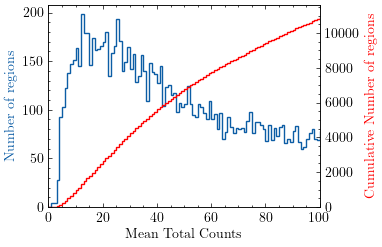

In [68]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.hist(df_regions_unique['mean_total_counts'], bins=np.arange(0,104,1), cumulative=False, histtype='step')
ax2.hist(df_regions_unique['mean_total_counts'], bins=np.arange(0,104,1), cumulative=True, histtype='step', color='red')
ax.set_ylabel('Number of regions', color='C0')
ax2.set_ylabel('Cumulative Number of regions', color='red')
ax.set_xlabel('Mean Total Counts')
plt.xlim(0,100)

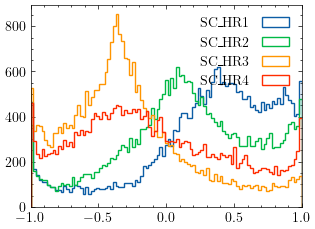

In [69]:
for c in ['SC_HR1','SC_HR2','SC_HR3','SC_HR4']:
    sub = dfs_cmatch['XMM DR14'][((dfs_cmatch['XMM DR14'][c] > -1) & (dfs_cmatch['XMM DR14'][c] < 1))]
    plt.hist(sub[c], bins=np.linspace(-1,1,100), histtype='step', label=c)
plt.legend(markerfirst=False)
plt.xlim(-1,1)
plt.show()

Text(0, 0.5, '0.2 - 12.0 keV Flux [erg/cm2/s]')

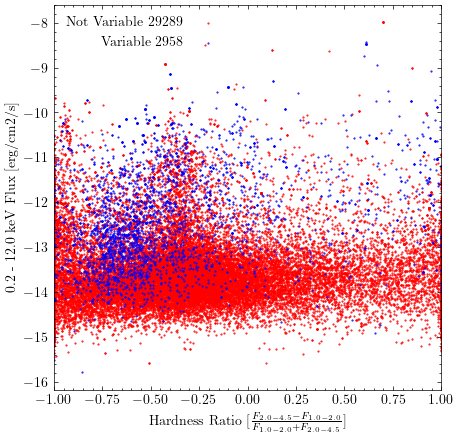

In [70]:
hr_dict = {'SC_HR1' : r'$\frac{F_{0.5-1.0} - F_{0.2-0.5}}{F_{0.2-0.5} + F_{0.5-1.0}}$',
           'SC_HR2' : r'$\frac{F_{1.0-2.0} - F_{0.5-1.0}}{F_{0.5-1.0} + F_{1.0-2.0}}$',
           'SC_HR3' : r'$\frac{F_{2.0-4.5} - F_{1.0-2.0}}{F_{1.0-2.0} + F_{2.0-4.5}}$',
           'SC_HR4' : r'$\frac{F_{4.5-12.0} - F_{2.0-4.5}}{F_{2.0-4.5} + F_{4.5-12.0}}$'}

df = dfs_cmatch['XMM DR14']
df_var  = df[df['SC_VAR_FLAG']]
df_nvar = df[~df['SC_VAR_FLAG']]

hr = 'SC_HR3'
plt.figure(figsize=(5,5))
plt.scatter(df_nvar[hr], np.log10(df_nvar['SC_EP_8_FLUX']), marker='.', s=1.0, color='red', label=f'Not Variable {len(df_nvar)}')
plt.scatter(df_var[hr], np.log10(df_var['SC_EP_8_FLUX']), marker='.', s=1.0, color='blue', label=f'Variable {len(df_var)}')
plt.xlim(-1,1)
plt.legend(markerfirst=False)
plt.xlabel(rf'Hardness Ratio [{hr_dict[hr]}]')
plt.ylabel('0.2 - 12.0 keV Flux [erg/cm2/s]')